# Setup server and load packages

In [4]:
#feel free to use the torch version that you prefer
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
#!pip3 install lightning
#!pip install pytorch-lightning --upgrade

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 2041.3 MB 31.0 MB/s eta 0:00:012    |███████                         | 441.4 MB 121.5 MB/s eta 0:00:14     |█████████████████████▊          | 1384.8 MB 49.1 MB/s eta 0:00:14     |██████████████████████▌         | 1437.3 MB 54.5 MB/s eta 0:00:12
     |████████████████████████████████| 23.2 MB 73.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 4.8 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1
    Uninstalling torch-2.2.1:
      Successfully uninstalled torch-2.2.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1
    Uninstalling torchvision-0.17.1:
      Successfully uninstalled torchvisio

In [1]:
# specify the GPU
import os
os.environ['TORCH_HOME'] = 'your/own/cache/directory'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
# Data visualization
import plotly.express as px
from ipywidgets import interact

# Data processing
import pandas as pd
import numpy as np
import geopandas as gpd

# Model training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import copy
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import timm
from sklearn.model_selection import train_test_split
# import lightning as L
# from lightning import Trainer
# from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Others
import os
from pathlib import Path
import os.path

In [3]:
torch.cuda.empty_cache()

In [4]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA A100-PCIE-40GB


# Load and prepare the data

In [5]:
directories = [
    Path('/workspace/workspace/ufo-prediction/image_data_NLD'),
    Path('/workspace/workspace/ufo-prediction/image_data_ESP'),  # Add your second directory path here
    Path('/workspace/workspace/ufo-prediction/image_data_FRA')   # Add your third directory path here
]

filepaths = pd.Series(
    [item for directory in directories for item in directory.glob('**/*.jpg')],
    name='Filepath'
).astype(str)

def get_age_bracket(age):
    if 1900 <= age <= 1924:
        return '1900-1924'
    elif 1925 <= age <= 1945:
        return '1925-1945'
    elif 1946 <= age <= 1959:
        return '1946-1959'
    elif 1960 <= age <= 1969:
        return '1960-1969'
    elif 1970 <= age <= 1984:
        return '1970-1984'
    elif 1985 <= age <= 1999:
        return '1985-1999'
    elif 2000 <= age <= 2050:
        return '2000-2050'
    else:
        return 'Unknown'  # For ages outside the specified brackets or if age couldn't be determined


def extract_age_and_name(filepath):
    filename = os.path.basename(filepath)  # Get the filename from the filepath
    age_and_name = filename.split('.')[0]  # Split by dot and take the first part
    age = ''.join(filter(str.isdigit, age_and_name))[:4]  # Extract first 4 digits for age
    if age:  # Ensure age string is not empty
        age = int(age)
        age_bracket = get_age_bracket(age)  # Get the age bracket
    else:  # Default age if no digits found
        age_bracket = 'Unknown'
    return age_bracket

age_bracket_to_int = {
    '1900-1924': 0,
    '1925-1945': 1,
    '1946-1959': 2,
    '1960-1969': 3,
    '1970-1984': 4,
    '1985-1999': 5,
    '2000-2050': 6
}

age_brackets = pd.Series(filepaths.apply(lambda x: extract_age_and_name(x)), name='Age Brackets')
filtered_age_brackets = age_brackets[age_brackets != 'Unknown']
filtered_filepaths = filepaths[age_brackets != 'Unknown']
trainval_df = pd.concat([filtered_filepaths, filtered_age_brackets], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
trainval_df['Target'] = trainval_df['Age Brackets'].map(age_bracket_to_int)

In [6]:
directory = Path('/workspace/workspace/ufo-prediction/image_data')

filepaths = pd.Series(list(directory.glob(r'**/*.jpg')), name='Filepath').astype(str)
age_brackets = pd.Series(filepaths.apply(lambda x: extract_age_and_name(x)), name='Age Brackets')
filtered_age_brackets = age_brackets[age_brackets != 'Unknown']
filtered_filepaths = filepaths[age_brackets != 'Unknown']

test_df = pd.concat([filtered_filepaths, filtered_age_brackets], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
test_df['Target'] = test_df['Age Brackets'].map(age_bracket_to_int)

In [7]:
train_df, val_df = train_test_split(trainval_df, train_size=0.7, shuffle=True, random_state=1)

In [8]:
class_counts = train_df['Target'].value_counts()
print(class_counts)

Target
4    1785
0    1621
6    1470
5    1347
1    1276
2    1275
3    1093
Name: count, dtype: int64


In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class AgeBracketDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = int(self.dataframe.iloc[idx, 2])  # Assuming the label/target is in the third column

        if self.transform:
            image = self.transform(image)

        return image, label


In [24]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # ResNet-18 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # A common form of augmentation
    #transforms.RandomRotation(15),  # Rotates the image by up to 15 degrees
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly jitters color
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = AgeBracketDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = AgeBracketDataset(val_df, transform=val_test_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

test_dataset = AgeBracketDataset(test_df, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


# Orginal model with low epochs, but balanced classes and data augumentation

In [25]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_classes = 7  # Example: 7 age brackets
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU if available


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)  # Optimize only the last layer

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%")

# Test evaluation (similar to validation step)
# After training and validation, you can use test_loader to evaluate the model's performance on the test set.

Epoch 1, Loss: 1.9822308901256642
Validation Loss: 1.9204739714568515, Accuracy: 21.11610309765902%
Epoch 2, Loss: 1.9355768962269664
Validation Loss: 1.9394187023054879, Accuracy: 22.132891936628045%
Epoch 3, Loss: 1.9341237604907884
Validation Loss: 1.9629094258794244, Accuracy: 24.00094585008276%
Epoch 4, Loss: 1.9257853531566973
Validation Loss: 1.902463255288466, Accuracy: 23.95365334594467%
Epoch 5, Loss: 1.9249306467016087
Validation Loss: 1.919242589878586, Accuracy: 23.598959564908963%
Epoch 6, Loss: 1.9202419523288596
Validation Loss: 1.9187204837799072, Accuracy: 24.42657838732561%
Epoch 7, Loss: 1.9228640191945303
Validation Loss: 1.9129760368815008, Accuracy: 24.355639631118468%
Epoch 8, Loss: 1.920040831960001
Validation Loss: 1.891689283442947, Accuracy: 24.379285883187514%
Epoch 9, Loss: 1.917263093218811
Validation Loss: 1.8968254444734105, Accuracy: 25.206904705604163%
Epoch 10, Loss: 1.9283863070331864
Validation Loss: 1.9108629402124657, Accuracy: 23.504374556632772

Test Accuracy: 0.28631
Test Precision: 0.37084
Test Recall: 0.28631
Test F1-Score: 0.27753


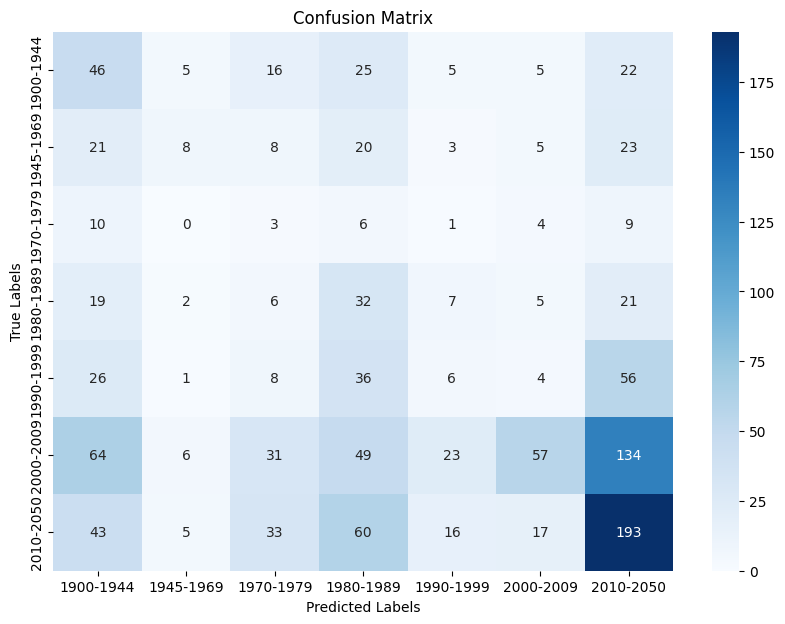

In [28]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure model is in evaluation mode
model.eval()

# Lists to store true and predicted labels
true_classes = []
predicted_classes = []

# No gradient is needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get prediction
        _, predicted = torch.max(outputs, 1)
        
        # Store labels and predictions
        true_classes.extend(labels.cpu().numpy())
        predicted_classes.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for evaluation metrics
true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Compute metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

print(f"Test Accuracy: {accuracy:.5f}")
print(f"Test Precision: {precision:.5f}")
print(f"Test Recall: {recall:.5f}")
print(f"Test F1-Score: {f1:.5f}")

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'], yticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [14]:
from sklearn.dummy import DummyClassifier
import numpy as np

dummy_stratified = DummyClassifier(strategy='stratified')
dummy_stratified.fit(np.zeros_like(true_classes), true_classes)  # X can be anything, as it's ignored
predictions_stratified = dummy_stratified.predict(np.zeros_like(true_classes))

# Calculate accuracy
accuracy_stratified = accuracy_score(true_classes, predictions_stratified)
print(f"Baseline Accuracy (Random Guessing): {accuracy_stratified:.5f}")

# Precision, Recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predictions_stratified, average='weighted')
print(f"Test Precision: {precision:.5f}")
print(f"Test Recall: {recall:.5f}")
print(f"Test F1-Score: {f1:.5f}")

Baseline Accuracy (Random Guessing): 0.16432
Test Precision: 0.16710
Test Recall: 0.16432
Test F1-Score: 0.16554


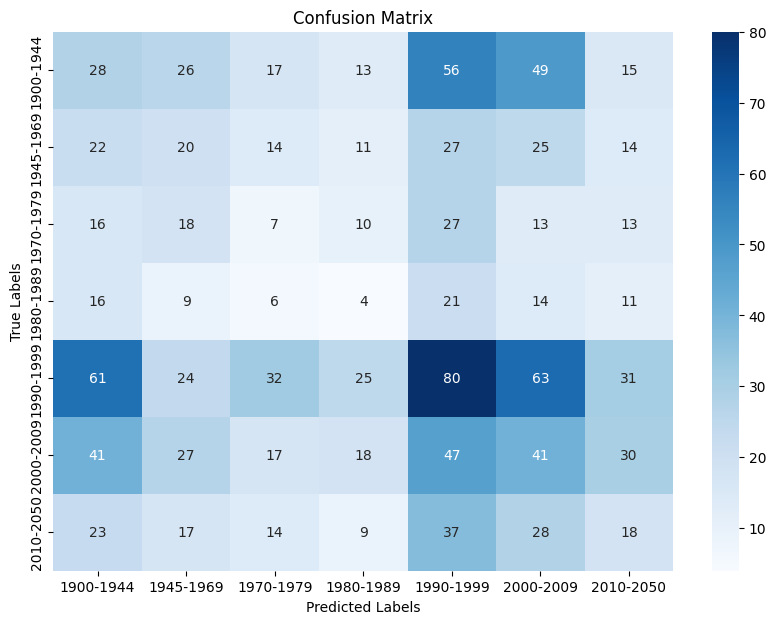

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming `true_classes` and `predicted_classes` are defined as before
cm = confusion_matrix(true_classes, predictions_stratified)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'], yticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Model 2: Increasing epochs to 500 with early stopping

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)  # Optimizing all parameters, adjust as needed

# Initialize early stopping parameters
patience = 15
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
early_stop = False

max_epochs = 500

for epoch in range(max_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f'Epoch {epoch+1}/{max_epochs}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}')
    
    # Check if the validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    # Check for early stopping
    if epochs_no_improve >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        early_stop = True
        break

if not early_stop:
    print('Reached maximum epoch limit.')

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/500, Training Loss: 1.9142, Validation Loss: 1.9811
Epoch 2/500, Training Loss: 1.9081, Validation Loss: 1.9471
Epoch 3/500, Training Loss: 1.9136, Validation Loss: 1.9390
Epoch 4/500, Training Loss: 1.9036, Validation Loss: 1.9228
Epoch 5/500, Training Loss: 1.9065, Validation Loss: 1.9638
Epoch 6/500, Training Loss: 1.9053, Validation Loss: 1.9701
Epoch 7/500, Training Loss: 1.9075, Validation Loss: 1.9639
Epoch 8/500, Training Loss: 1.9072, Validation Loss: 1.8972
Epoch 9/500, Training Loss: 1.9091, Validation Loss: 1.9548
Epoch 10/500, Training Loss: 1.9038, Validation Loss: 1.9380
Epoch 11/500, Training Loss: 1.9067, Validation Loss: 1.9268
Epoch 12/500, Training Loss: 1.9037, Validation Loss: 2.0008
Epoch 13/500, Training Loss: 1.9011, Validation Loss: 1.9827
Epoch 14/500, Training Loss: 1.9035, Validation Loss: 1.9080
Epoch 15/500, Training Loss: 1.9041, Validation Loss: 1.9260
Epoch 16/500, Training Loss: 1.9077, Validation Loss: 1.9109
Epoch 17/500, Training Loss: 1.89

<All keys matched successfully>

Test Accuracy: 0.19004
Test Precision: 0.34863
Test Recall: 0.19004
Test F1-Score: 0.19805


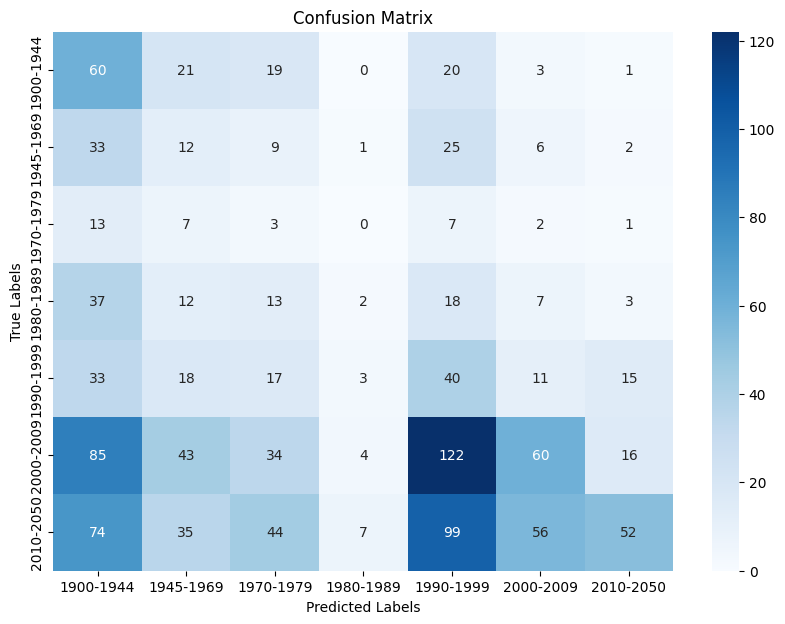

In [16]:
# Ensure model is in evaluation mode
model.eval()

# Lists to store true and predicted labels
true_classes = []
predicted_classes = []

# No gradient is needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get prediction
        _, predicted = torch.max(outputs, 1)
        
        # Store labels and predictions
        true_classes.extend(labels.cpu().numpy())
        predicted_classes.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for evaluation metrics
true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Compute metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

print(f"Test Accuracy: {accuracy:.5f}")
print(f"Test Precision: {precision:.5f}")
print(f"Test Recall: {recall:.5f}")
print(f"Test F1-Score: {f1:.5f}")

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'], yticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 3. Model using an optmiser

In [17]:
import torch
import torch.nn as nn
import copy
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)  # Optimizing all parameters

# Setup the ReduceLROnPlateau learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Initialize early stopping parameters
patience = 15
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
early_stop = False

max_epochs = 500

for epoch in range(max_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f'Epoch {epoch+1}/{max_epochs}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}')
    
    # Step the scheduler on each epoch
    scheduler.step(avg_val_loss)
    
    # Check if the validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    # Early stopping check
    if epochs_no_improve >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        early_stop = True
        break

if not early_stop:
    print('Reached maximum epoch limit.')

# Load best model weights
model.load_state_dict(best_model_wts)


Epoch 1/500, Training Loss: 1.9106, Validation Loss: 1.9260
Epoch 2/500, Training Loss: 1.8999, Validation Loss: 1.9220
Epoch 3/500, Training Loss: 1.9073, Validation Loss: 1.9210
Epoch 4/500, Training Loss: 1.9039, Validation Loss: 1.9493
Epoch 5/500, Training Loss: 1.9032, Validation Loss: 1.9258
Epoch 6/500, Training Loss: 1.9115, Validation Loss: 1.8976
Epoch 7/500, Training Loss: 1.8979, Validation Loss: 1.9583
Epoch 8/500, Training Loss: 1.9025, Validation Loss: 1.9164
Epoch 9/500, Training Loss: 1.8967, Validation Loss: 2.0205
Epoch 10/500, Training Loss: 1.9051, Validation Loss: 1.8928
Epoch 11/500, Training Loss: 1.9081, Validation Loss: 1.9396
Epoch 12/500, Training Loss: 1.8998, Validation Loss: 1.9463
Epoch 13/500, Training Loss: 1.8880, Validation Loss: 1.9251
Epoch 14/500, Training Loss: 1.8870, Validation Loss: 1.9172
Epoch 15/500, Training Loss: 1.9020, Validation Loss: 1.9945
Epoch 16/500, Training Loss: 1.9174, Validation Loss: 1.9562
Epoch    16: reducing learning ra

<All keys matched successfully>

Test Accuracy: 0.23154
Test Precision: 0.35878
Test Recall: 0.23154
Test F1-Score: 0.24345


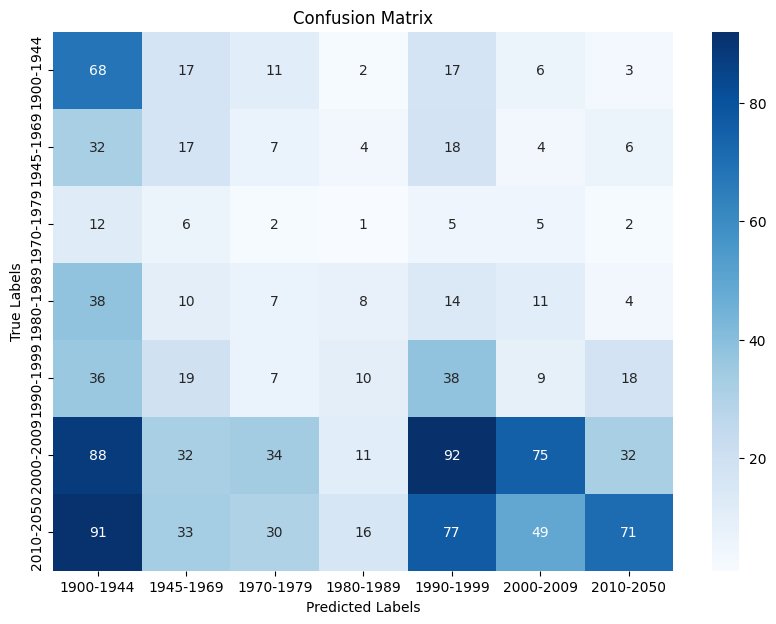

In [18]:
# Ensure model is in evaluation mode
model.eval()

# Lists to store true and predicted labels
true_classes = []
predicted_classes = []

# No gradient is needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get prediction
        _, predicted = torch.max(outputs, 1)
        
        # Store labels and predictions
        true_classes.extend(labels.cpu().numpy())
        predicted_classes.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for evaluation metrics
true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Compute metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

print(f"Test Accuracy: {accuracy:.5f}")
print(f"Test Precision: {precision:.5f}")
print(f"Test Recall: {recall:.5f}")
print(f"Test F1-Score: {f1:.5f}")

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'], yticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Model 4: Gridsearch over learning rate, layers and batch size

In [29]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=500, patience=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels.data)
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct_preds.double() / total

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        
        scheduler.step(avg_val_loss)  # Learning rate scheduler step

        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            early_stop = True
            break
    
    if not early_stop:
        print('Reached maximum epoch limit.')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return best_val_acc.item()  # Return the best validation accuracy achieved


In [30]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example hyperparameters for the grid search
batch_sizes = [16, 32]  # Add more as needed
learning_rates = [0.001, 0.0005]  # Add more as needed
unfreeze_options = ['last', 'last_plus_one']  # Options for layers to unfreeze

# Placeholder for best model's performance
best_accuracy = 0
best_params = {}

# Your train_and_evaluate function here

for batch_size in batch_sizes:
    for lr in learning_rates:
        for unfreeze_option in unfreeze_options:
            print(f"Training with batch size: {batch_size}, learning rate: {lr}, unfreeze option: {unfreeze_option}")

            # Load a pretrained ResNet model
            model = models.resnet18(pretrained=True)
            
            # Freeze all parameters first
            for param in model.parameters():
                param.requires_grad = False
            
            # Unfreeze the last layer (fc) or last block (layer4) + fc based on unfreeze_option
            if unfreeze_option == 'last':
                for param in model.fc.parameters():
                    param.requires_grad = True
            elif unfreeze_option == 'last_plus_one':
                # Unfreeze both the last block and the fully connected layer
                for param in model.layer4.parameters():
                    param.requires_grad = True
                for param in model.fc.parameters():
                    param.requires_grad = True
            
            model.to(device)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
            criterion = nn.CrossEntropyLoss()
            scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)
            
            # Run training and evaluation
            val_acc = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, scheduler)

            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = {'batch_size': batch_size, 'learning_rate': lr, 'unfreeze_option': unfreeze_option}

print(f"Best Parameters: {best_params}, Best Validation Accuracy: {best_accuracy}")


Training with batch size: 16, learning rate: 0.001, unfreeze option: last
Epoch 1/500, Training Loss: 2.3574, Validation Loss: 2.0909, Val Accuracy: 0.1840
Epoch 2/500, Training Loss: 2.0205, Validation Loss: 1.9748, Val Accuracy: 0.2197
Epoch 3/500, Training Loss: 1.9724, Validation Loss: 1.9285, Val Accuracy: 0.2329
Epoch 4/500, Training Loss: 1.9562, Validation Loss: 1.9870, Val Accuracy: 0.2168
Epoch 5/500, Training Loss: 1.9261, Validation Loss: 1.9166, Val Accuracy: 0.2379
Epoch 6/500, Training Loss: 1.9270, Validation Loss: 1.9317, Val Accuracy: 0.2457
Epoch 7/500, Training Loss: 1.9107, Validation Loss: 1.9021, Val Accuracy: 0.2490
Epoch 8/500, Training Loss: 1.9199, Validation Loss: 1.8918, Val Accuracy: 0.2476
Epoch 9/500, Training Loss: 1.9199, Validation Loss: 1.9550, Val Accuracy: 0.2391
Epoch 10/500, Training Loss: 1.9133, Validation Loss: 1.9678, Val Accuracy: 0.2419
Epoch 11/500, Training Loss: 1.9210, Validation Loss: 1.9232, Val Accuracy: 0.2445
Epoch 12/500, Training

In [ ]:
class AgeClassificationModel(LightningModule):
    def __init__(
        self,
        model: torch.nn.Module,
        learning_rate: float = 1e-3,
        pos_weight: float = 1.0,
    ):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.pos_weight = pos_weight
        self.loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight))

    def forward(self, x):
        preds = self.model(x).squeeze(-1)
        return preds


# Finetuning

In [ ]:

class ResNetAdaptable(torch.nn.Module):
    def __init__(self,
                 num_input_channels: int = 3,
                 num_classes: int = 1,
                 head_lin_features: int = 256,
                 num_unfreeze_layers: int = 1):
        super(ResNetAdaptable, self).__init__()

        assert 1 <= num_unfreeze_layers <= 4, "Number of unfrozen layers must be between 1 and 4"

        self.num_input_channels = num_input_channels
        self.num_classes = num_classes
        self.head_lin_features = head_lin_features

        # Load the ResNet50 architecture from torchvision
        resnet = models.resnet50(pretrained=True)

        # Replace the first convolutional layer to adapt to the number of input channels
        resnet.conv1 = torch.nn.Conv2d(self.num_input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Freeze all parameters of the model first
        for param in resnet.parameters():
            param.requires_grad = False

        # Unfreeze the last `num_unfreeze_layers` layers
        if num_unfreeze_layers >= 1:
            for param in resnet.layer4.parameters():
                param.requires_grad = True
        if num_unfreeze_layers >= 2:
            for param in resnet.layer3.parameters():
                param.requires_grad = True
        if num_unfreeze_layers >= 3:
            for param in resnet.layer2.parameters():
                param.requires_grad = True
        if num_unfreeze_layers == 4:
            for param in resnet.layer1.parameters():
                param.requires_grad = True

        # Customize the output head of the ResNet
        num_features = resnet.fc.in_features
        model_head = torch.nn.Sequential(
            torch.nn.Linear(num_features, head_lin_features),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(head_lin_features, self.num_classes)
        )
        resnet.fc = model_head

        self.model = resnet

    def forward(self, x):
        return self.model(x)


In [ ]:
# treat ResNet and the number of features in the head layer as hps
hp_dict_ResNet = {"num_unfreeze_layers": [1, 2, 3, 4],
           "head_lin_features": [64, 128, 256, 512]
           }

hp_trainer_confi_ResNet = {'max_epochs': 100, # reduced to 10 from 100
 'callbacks': [EarlyStopping(monitor="loss", mode="min", patience=10, min_delta=0.00)],
 'limit_train_batches': round(1 * len(data.train_dataset.gdf) / batch_size),
 'limit_val_batches': round(1 * len(data.val_dataset.gdf) / batch_size),
 'reload_dataloaders_every_n_epochs': 1,
 'precision': '16-mixed',
 'accelerator': 'gpu',
 'logger': True,
 'log_every_n_steps': 1}

my_tuner_ResNet = MyTuner(model_class = ResNetAdaptable, trainer_config = hp_trainer_confi_ResNet, max_iter=10)

In [ ]:
best_hp_ResNet, best_hp_ResNet_val = my_tuner_ResNet.grid_search(data, hp_dict_ResNet)

In [ ]:
print(f"Best hyperparameter selection with grid search: {best_hp_ResNet}, achieved score: {best_hp_ResNet_val: .2f}")

In [ ]:
pretrained_lit_model = AgeClassificationModel(
    model=ResNetAdaptable(**best_hp_ResNet),
    learning_rate=1e-3,
    pos_weight=data.pos_weight,
)

In [ ]:
pretrained_trainer = Trainer(**hp_trainer_confi_ResNet)
pretrained_trainer.fit(pretrained_lit_model, data)

In [ ]:
_ = pretrained_trainer.test(
    model=pretrained_lit_model,
    dataloaders=data,
    ckpt_path="best",
    verbose=True,
)